In [7]:
import torch
from datasets import load_dataset, Dataset, Features, ClassLabel, Image
from huggingface_hub import HfApi, HfFolder

In [8]:
# Step 1: Load the MNIST and FashionMNIST datasets
mnist = load_dataset("ylecun/mnist")
fashion_mnist = load_dataset("fashion_mnist")

In [9]:
# Step 2: Extract T-shirt images (label 0) from FashionMNIST
fashion_train = fashion_mnist['train']
tshirt_indices = [i for i, label in enumerate(fashion_train['label']) if label == 0]

In [10]:
fashion_train['image'][1]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f18d8197b20>>
Traceback (most recent call last):
  File "/home/claserken/mambaforge/envs/diffusion/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [9]:
# Select the first 606 T-shirt images
tshirt_images = [fashion_train['image'][1]] * 606

In [10]:
# Step 3: Combine MNIST images with the T-shirt images
mnist_images = mnist['train']['image']
mnist_labels = mnist['train']['label']

In [11]:
# Assign a new label (e.g., 10) for T-shirt images
tshirt_labels = [10] * 606

In [12]:
# Combine the images and labels
combined_images = mnist_images + tshirt_images
combined_labels = mnist_labels + tshirt_labels

In [13]:
# Step 4: Create a new dataset with combined images and labels
features = Features({
    'image': Image(),
    'label': ClassLabel(names=[str(i) for i in range(10)] + ["tshirt"])
})

combined_dataset = Dataset.from_dict({
    'image': combined_images,
    'label': combined_labels
}, features=features)

In [14]:
# Push the dataset to the HF Hub
combined_dataset.push_to_hub("claserken/mnist-with-tshirt", private=True)

Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/claserken/mnist-with-tshirt/commit/19b8485500f109df6269fb6eb0921f80e3327e37', commit_message='Upload dataset', commit_description='', oid='19b8485500f109df6269fb6eb0921f80e3327e37', pr_url=None, pr_revision=None, pr_num=None)

In [22]:
# Step 6: Test the uploaded dataset by loading it from the Hugging Face Hub
# Load the new dataset from the Hub
loaded_dataset = load_dataset("claserken/mnist-with-tshirt")

# Print some information to verify it works
print("Dataset loaded successfully!")
print(f"Number of examples: {len(loaded_dataset['train'])}")

# Display a random sample to ensure it contains both MNIST and T-shirt images
sample = loaded_dataset['train']
for i, item in enumerate(sample):
    print(f"Sample {i}: Label = {item['label']}")

Dataset loaded successfully!
Number of examples: 60606
Sample 0: Label = 5
Sample 1: Label = 0
Sample 2: Label = 4
Sample 3: Label = 1
Sample 4: Label = 9
Sample 5: Label = 2
Sample 6: Label = 1
Sample 7: Label = 3
Sample 8: Label = 1
Sample 9: Label = 4
Sample 10: Label = 3
Sample 11: Label = 5
Sample 12: Label = 3
Sample 13: Label = 6
Sample 14: Label = 1
Sample 15: Label = 7
Sample 16: Label = 2
Sample 17: Label = 8
Sample 18: Label = 6
Sample 19: Label = 9
Sample 20: Label = 4
Sample 21: Label = 0
Sample 22: Label = 9
Sample 23: Label = 1
Sample 24: Label = 1
Sample 25: Label = 2
Sample 26: Label = 4
Sample 27: Label = 3
Sample 28: Label = 2
Sample 29: Label = 7
Sample 30: Label = 3
Sample 31: Label = 8
Sample 32: Label = 6
Sample 33: Label = 9
Sample 34: Label = 0
Sample 35: Label = 5
Sample 36: Label = 6
Sample 37: Label = 0
Sample 38: Label = 7
Sample 39: Label = 6
Sample 40: Label = 1
Sample 41: Label = 8
Sample 42: Label = 7
Sample 43: Label = 9
Sample 44: Label = 3
Sample 45:

In [26]:
sample[-607]['image']

AttributeError: 'PngImageFile' object has no attribute 'shape'

In [11]:
# TShirt classifier using L2
import sys
sys.path.append('/home/claserken/Developer/dataunlearning')

In [12]:
from metrics.tshirt import TShirtClassifier
import torchvision.transforms as transforms
transform = transforms.ToTensor()

In [13]:
tshirt = transform(fashion_train['image'][1])

In [14]:
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [15]:
digit_tensors = [transform(entry['image']) for entry in mnist['train']] 

In [16]:
digit_tensors = torch.stack(digit_tensors)

In [19]:
l2_distances, freq = TShirtClassifier.get_tshirt_frequency(digit_tensors, tshirt)

In [21]:
l2_distances.mean()

tensor(14.6078)

In [28]:
l2_distances.min()

tensor(11.4851)

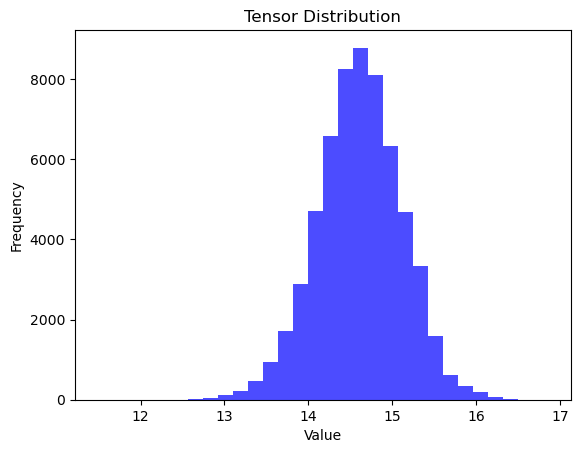

In [27]:
import matplotlib.pyplot as plt

# Plot the distribution using Seaborn
plt.hist(l2_distances, bins=30, alpha=0.7, color='b')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Tensor Distribution')
plt.show()

In [30]:
tshirt.shape

torch.Size([1, 28, 28])

In [32]:
digit_tensors[0].shape

torch.Size([1, 28, 28])

In [37]:
torch.sqrt(torch.sum((tshirt - digit_tensors[0]) ** 2))

tensor(14.7564)